1. Run a Linear Discriminant Analysis based on quantitative environmental variables (see previous
exercises), using the Douro and Tejo basins as the pre-determined groups. Produce a biplot with
‘Catchment_name’ as a grouping variable.
2. Try to build interactive plots that display data in the space defined by the Discriminant Functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [2]:
#import and prep data for Linear Discriminant Analysis

df = pd.read_csv('EFIplus_medit.zip',compression='zip', sep=";")
df = df.dropna() # remove all rows with missing data
# Subset the df by selecting the environmental variables and the species richness columns
dfsub = df[(df['Catchment_name']=='Douro') | (df['Catchment_name']=='Tejo') | (df['Catchment_name']=='Minho') | (df['Catchment_name']=='Mondego')]
df_env = dfsub[["Altitude", "Actual_river_slope","Elevation_mean_catch", "prec_ann_catch","temp_ann","temp_jan","temp_jul"]]
df_catch = dfsub[["Catchment_name"]]

efi_scaled = StandardScaler().fit_transform(df_env)
# As a result, we obtained a two-dimensional NumPy array. We can convert it to a pandas DataFrame for a better display.
df_scaled = pd.DataFrame(data=efi_scaled, 
                                columns=df_env.columns)
df_scaled.head()

,Altitude,Actual_river_slope,Elevation_mean_catch,prec_ann_catch,temp_ann,temp_jan,temp_jul
0,2.317434,-0.792732,2.286957,-1.089865,-1.749363,-1.868883,-0.917168
1,1.853915,-0.676045,1.253702,-1.815993,-1.236037,-1.548490,-0.331631
2,0.532391,-0.779186,0.398903,-2.433332,-0.209383,-0.907706,0.497880
3,1.367384,-0.642389,0.716150,-2.252746,-0.862708,-1.348245,0.107522
4,1.308211,-0.610283,0.445796,-2.411039,-0.909374,-1.388294,-0.136452


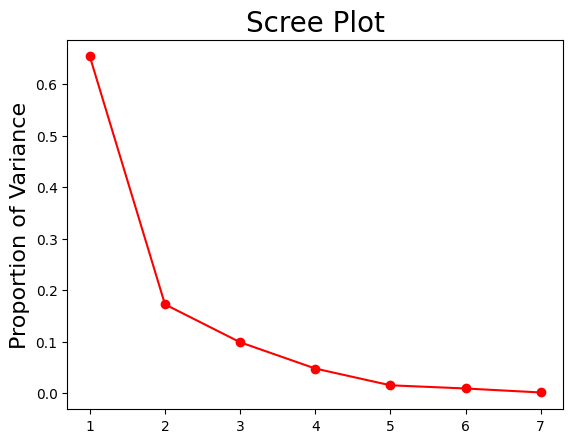

In [15]:
# define predictor and response variables

X = df_scaled
y = dfsub['Catchment_name'] # 4 classes (Tagus, Douro and Minho and Mondego)

#Fit the LDA model
model = LinearDiscriminantAnalysis(n_components=2)
DLA = model.fit_transform(X, y)

# select number of PCs
pca = PCA(n_components=7)
pca.fit_transform(df_scaled)
eigenvalues = pca.explained_variance_ # eigenvalues
prop_var = pca.explained_variance_ratio_ # proportion of explained variance

# Scree Plot
PC_numbers = np.arange(pca.n_components_) + 1
 
plt.plot(PC_numbers, 
         prop_var,
         'ro-')
plt.title('Scree Plot', fontsize=20)
plt.ylabel('Proportion of Variance', fontsize=16)
plt.show()

In [4]:
#will select 2 PC's because of scree plot results--leves off after 2 and 3

pca = PCA(n_components=2)
PC = pca.fit_transform(df_scaled)
pca_efi = pd.DataFrame(data = PC, 
                            columns = ['PC1', 'PC2'])
pca_efi.head(6)

,PC1,PC2
0,3.682106,-2.345615
1,2.383697,-2.633798
2,0.269847,-2.766732
3,1.471039,-2.812037
4,1.456941,-2.835882
5,0.457595,-2.874873


In [5]:
#extract the first 2 discriminant axis to a data frame

DLA_scores = pd.DataFrame(data = DLA, 
                            columns = ['LD1', 'LD2'])
DLA_scores.head(6)

,LD1,LD2
0,0.043208,1.024932
1,-0.625294,-0.420343
2,-0.629831,-1.698250
3,-0.563926,-1.386428
4,0.110545,-1.671937
5,-1.217251,-2.053460


In [6]:
#defines the kfold crossvalidation settings for the next function 'cross_val_score'
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) 

#evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))

0.8869966209501093


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


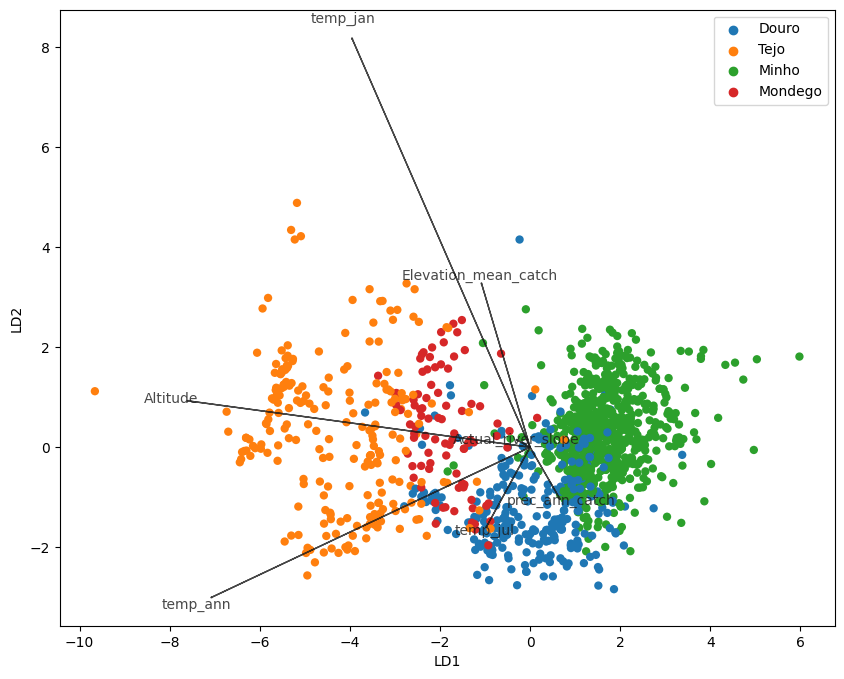

In [7]:
#plot the discriminant plane
plt.figure(figsize=(10, 8))

sns.scatterplot(x=DLA_scores['LD1'],
              y=DLA_scores['LD2'],
              hue = dfsub['Catchment_name'].tolist(),
              linewidth=0,
              )

n = model.n_features_in_
for i in range(n):
        plt.arrow(0, 0, model.scalings_[i,0]*2, # Scalings were multiplied by a factor of 4 to just to facilitate the visualization
                  model.scalings_[i,1]*2, # Scalings were multiplied by a factor of 4 to just to facilitate the visualization
                  color = (0.1, 0.1, 0.1, 0.8),
                  head_width=0.02) # plot arrows for each variable
        plt.text(model.scalings_[i,0]*2.1, # plot the names of the variables
                 model.scalings_[i,1]*2.1,
                 list(df_scaled)[i], 
                 color = (0.1, 0.1, 0.1, 0.8), 
                 ha = 'center', 
                 va = 'center') # variable labels for each arrow

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.show()

In [8]:
df_scaled.head()

,Altitude,Actual_river_slope,Elevation_mean_catch,prec_ann_catch,temp_ann,temp_jan,temp_jul
0,2.317434,-0.792732,2.286957,-1.089865,-1.749363,-1.868883,-0.917168
1,1.853915,-0.676045,1.253702,-1.815993,-1.236037,-1.548490,-0.331631
2,0.532391,-0.779186,0.398903,-2.433332,-0.209383,-0.907706,0.497880
3,1.367384,-0.642389,0.716150,-2.252746,-0.862708,-1.348245,0.107522
4,1.308211,-0.610283,0.445796,-2.411039,-0.909374,-1.388294,-0.136452


Interactive mapping

In [9]:
from bokeh.io import curdoc, output_notebook, show
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, Slider
from bokeh.palettes import Spectral6
from bokeh.layouts import column, row

In [10]:
# load BokehJS - enables the plot to be displayed within the notebook
output_notebook()

Loading BokehJS ...

In [28]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, Arrow, VeeHead, CategoricalColorMapper
import pandas as pd

# Assuming you have DLA_scores and model.scalings_ from your analysis

# Prepare data for Bokeh
source = ColumnDataSource(data={
    'LD1': DLA_scores['LD1'],
    'LD2': DLA_scores['LD2'],
    'Catchment_name': dfsub['Catchment_name'].tolist(),
})

# Define a color mapper for catchment names
color_mapper = CategoricalColorMapper(factors=dfsub['Catchment_name'].unique(), palette=['red', 'green', 'blue', 'orange'])

# Create the figure
p = figure(width=800, height=600, title="Discriminant Function Analysis",
           x_axis_label='LD1', y_axis_label='LD2')

# Add scatter points with color mapped to catchment name
scatter = p.scatter('LD1', 'LD2', source=source, legend_field='Catchment_name', 
                    fill_alpha=0.6, size=8, color={'field': 'Catchment_name', 'transform': color_mapper})

# Add arrows for each variable
n = model.n_features_in_
for i in range(n):
    p.add_layout(Arrow(end=VeeHead(size=10), x_start=0, y_start=0, 
                       x_end=model.scalings_[i, 0]*2, y_end=model.scalings_[i, 1]*2,
                       line_color="black"))

    p.text(x=[model.scalings_[i, 0]*2.1], y=[model.scalings_[i, 1]*2.1],
           text=[list(df_scaled)[i]], text_align='center', text_baseline='middle')

# Add hover tool
hover = HoverTool()
hover.tooltips = [
    ("Catchment", "@Catchment_name"),
    ("LD1", "@LD1"),
    ("LD2", "@LD2"),
]
p.add_tools(hover)

# Show the plot
output_notebook()
show(p, notebook_handle=True)


Loading BokehJS ...

Data separated by altitude and temp_ann

In [23]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper

# Prepare data for Bokeh
source = ColumnDataSource(data={
    'Altitude': df_env["Altitude"],
    'temp_ann': df_env["temp_ann"],
    'Catchment_name': df_catch["Catchment_name"],
})

# Define a color mapper for catchment names
color_mapper = CategoricalColorMapper(factors=df_catch["Catchment_name"].unique(), 
                                      palette=['red', 'green', 'blue', 'purple', 'orange'])

# Create the figure
p = figure(width=800, height=600, title="Altitude vs. Annual Temperature",
           x_axis_label='Altitude', y_axis_label='Annual Temperature')

# Add scatter points with color mapped to catchment name
scatter = p.circle('Altitude', 'temp_ann', source=source, legend_field='Catchment_name', 
                   fill_alpha=0.6, size=8, color={'field': 'Catchment_name', 'transform': color_mapper})

# Add hover tool
hover = HoverTool()
hover.tooltips = [
    ("Catchment", "@Catchment_name"),
    ("Altitude", "@Altitude"),
    ("Annual Temperature", "@temp_ann"),
]
p.add_tools(hover)

# Show the plot
output_notebook()
show(p)


/var/folders/nx/dr_pnkkn1yg156jk80s020sc0000gn/T/ipykernel_1760/2028284491.py:20: BokehDeprecationWarning:

'circle() method with size value' was deprecated in Bokeh 3.4.0 and will be removed, use 'scatter(size=...) instead' instead.



Loading BokehJS ...